In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display
from collections import namedtuple, deque
import itertools

import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import json
import sys
import gym
import io

from gym import wrappers
from subprocess import check_output
from IPython.display import HTML

%matplotlib inline

In [165]:
class FCQ(nn.Module):
    def __init__(self, 
                 input_dim,
                 output_dim,
                 hidden_dims=(32,32),
                 activation_fc=F.relu,
                 output_activation_fc=None,
                 seed=123,
                 device='cpu'):
        super(FCQ, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.activation_fc = activation_fc
        self.output_activation_fc = output_activation_fc

        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dims)-1):
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)

        self.device = device
        self.to(self.device)

    def forward(self, state):
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, device=self.device, dtype=torch.float32)        
        x = self.activation_fc(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation_fc(hidden_layer(x))
        x = self.output_layer(x)
        return x if not self.output_activation_fc else self.output_activation_fc(x)
    
    def load_experiences(self, experiences):
        states, actions, new_states, rewards, is_terminals = experiences
        states = torch.from_numpy(states).float().to(self.device)
        actions = torch.from_numpy(actions).long().to(self.device)
        new_states = torch.from_numpy(new_states).float().to(self.device)
        rewards = torch.from_numpy(rewards).float().to(self.device)
        is_terminals = torch.from_numpy(is_terminals).float().to(self.device)
        return states, actions, new_states, rewards, is_terminals

In [166]:
class ReplayBuffer():
    def __init__(self, max_samples=100000):
        self.memory = deque(maxlen=max_samples)
    def store(self, sample):
        self.memory.append(sample)
    def sample(self, batch_size=64):
        idxs = np.random.choice(len(self.memory), batch_size)
        samples = np.array([self.memory[idx] for idx in idxs])
        batches = [np.vstack(batch_type) for batch_type in samples.T]
        return batches
    def __len__(self):
        return len(self.memory)

In [167]:
class EGreedyLinearStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=0.995, min_epsilon=0.01):
        self.epsilon = init_epsilon
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def select_action(self, q_network, state):
        nA = q_network.output_layer.out_features
        action = np.random.randint(nA)
        if np.random.rand() > self.epsilon:
            with torch.no_grad():
                q_values = q_network(state).cpu().data.numpy()
                action = np.argmax(q_values)
        self.epsilon = max(self.min_epsilon, self.decay_rate*self.epsilon)
        return action

In [168]:
class EGreedyDecayStrategy():
    def __init__(self, init_epsilon=1.0, decay_rate=1e-4, min_epsilon=0.1):
        self.t = 0
        self.init_epsilon = init_epsilon
        self.decay_rate = decay_rate
        self.min_epsilon = min_epsilon

    def select_action(self, q_network, state):
        nA = q_network.output_layer.out_features
        epsilon = max(self.init_epsilon * np.exp(-self.decay_rate * self.t), 
                      self.min_epsilon)
        #if self.t % 100 == 0:
        # print(epsilon)
        action = np.random.randint(nA)
        if np.random.rand() > epsilon:
            with torch.no_grad():
                q_values = q_network(state).cpu().data.numpy()
                action = np.argmax(q_values)
        self.t += 1
        return action

In [169]:
class SoftMaxStrategy():
    def __init__(self, init_temp=1.0, decay_rate=1e-3, min_temp=1e-2):
        self.t = 0
        self.init_temp = init_temp
        self.decay_rate = decay_rate
        self.min_temp = min_temp

    def select_action(self, q_network, state):
        nA = q_network.output_layer.out_features
        nS = q_network.input_layer.in_features
 
        temp = max(self.init_temp * np.exp(-self.decay_rate * self.t), 
                   self.min_temp)
        q_values = np.random.rand(nS)
        with torch.no_grad():
            q_values = q_network(state).cpu().data.numpy()
        probs = np.exp(q_values/temp) / np.sum(np.exp(q_values/temp))
        action = np.random.choice(np.arange(nA), size=1, p=probs)[0]
        self.t += 1
        return action

In [174]:
class DQNAgent():
    def __init__(self, replay_buffer, q_network, q_target, optimizer, behavioral_strategy):
        self.replay_buffer = replay_buffer
        self.q_network = q_network
        self.q_target = q_target
        self.optimizer = optimizer
        self.behavioral_strategy = behavioral_strategy

    def train(self, env, max_episodes, max_mean_reward):
        gamma = 1.0
        nS = env.observation_space.shape[0]
        nA = env.action_space.n
        total_timestep = 0
        episode_reward = []
        for episode in itertools.count():
            state, done = env.reset(), False
            episode_reward.append(0)
            for timestep in itertools.count():
                self.q_network.eval()

                action = self.behavioral_strategy.select_action(self.q_network, state)
                new_state, reward, is_terminal, _ = env.step(action)
                episode_reward[-1] += reward

                experience = (state, action, reward, new_state, float(is_terminal))
                self.replay_buffer.store(experience)
                state = new_state
                
                if len(self.replay_buffer) > 100:
                    self.q_network.train()
                    experiences = self.replay_buffer.sample()
                    experiences = self.q_network.load_experiences(experiences)
                    states, actions, rewards, new_states, is_terminals = experiences

                    q_nexts = self.q_target(new_states).detach().max(1)[0].unsqueeze(1)
                    q_targets = rewards + (gamma * q_nexts * (1.0 - is_terminals))
                    current_q = self.q_network(states).gather(1, actions)

                    loss = F.mse_loss(current_q, q_targets)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                    total_timestep += 1
                
                    if total_timestep % 10 == 0:
                        self.q_target.load_state_dict(self.q_network.state_dict())
                        #tau = 1e-3
                        #for target_param, local_param in zip(self.q_target.parameters(), self.q_network.parameters()):
                        #    target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
                    
                if is_terminal:
                    break

            if episode % 100 == 0:
                print('episode {}, mean reward {:.2f}'.format(episode, np.mean(episode_reward)))
            if episode % 1000 == 0:
                torch.save(agent.q_network.state_dict(), 'checkpoint_{}.pth'.format(episode))
            if episode >= 5000:
                break

In [175]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True, mode='training')
env.seed(1234)
nS = env.observation_space.shape[0]
nA = env.action_space.n

replay_buffer = ReplayBuffer()
q_network = FCQ(nS, nA, hidden_dims=(64,64), device=device)
q_target = FCQ(nS, nA, hidden_dims=(64,64), device=device)
optimizer = optim.RMSprop(q_network.parameters(), lr=0.001)
behavioral_strategy = EGreedyDecayStrategy()

agent = DQNAgent(replay_buffer, 
                 q_network, 
                 q_target, 
                 optimizer, 
                 behavioral_strategy)

cuda:0


In [176]:
mdir = tempfile.mkdtemp()
env = gym.make('CartPole-v0')
env = wrappers.Monitor(env, mdir, force=True, mode='training')
agent.train(env, 10, 200)

episode 0, mean reward 17.00
episode 100, mean reward 33.49
episode 200, mean reward 83.10
episode 300, mean reward 121.80
episode 400, mean reward 141.18
episode 500, mean reward 152.92
episode 600, mean reward 160.76
episode 700, mean reward 158.82
episode 800, mean reward 141.33
episode 900, mean reward 135.74
episode 1000, mean reward 140.75
episode 1100, mean reward 143.48
episode 1200, mean reward 133.06
episode 1300, mean reward 123.60
episode 1400, mean reward 115.48


KeyboardInterrupt: 

In [139]:
env.render(close=True)
env.close()

In [5]:
state, done = env.reset(), False
while True:
    _, _, done, _ = env.step(env.action_space.sample())
    if done:
        break
env.close()

In [15]:
def get_videos_html(env_videos, max_n_videos=3):
    videos = np.array(env_videos=videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = ''
    for video_path, meta_path in videos:
        video = io.open(video_path, 'r+b').read()
        encoded = base64.b64encode(video)

        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h2>{0}<h2/>
        <video width="960" height="540" controls>
            <source src="data:video/mp4;base64,{1}" type="video/mp4" />
        </video>"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm

In [43]:
HTML(data=get_videos_html(env.videos))

In [77]:
def get_gif_html(env_videos, max_n_videos=3):
    videos = np.array(env_videos)
    n_videos = min(max_n_videos, len(videos))
    idxs = np.linspace(0, len(videos) - 1, n_videos).astype(int)
    videos = videos[idxs,:]

    strm = ''
    for video_path, meta_path in videos:
        basename = os.path.splitext(video_path)[0]
        gif_path = basename + '.gif'
        if not os.path.exists(gif_path):
            ps = subprocess.Popen(
                ('ffmpeg', 
                 '-i', video_path, 
                 '-r', '10', 
                 '-f', 'image2pipe', 
                 '-vcodec', 'ppm', 
                 '-'), 
                stdout=subprocess.PIPE)
            output = subprocess.check_output(
                ('convert', 
                 '-delay', '5', 
                 '-loop', '0', 
                 '-', gif_path), 
                stdin=ps.stdout)
            ps.wait()

        gif = io.open(gif_path, 'r+b').read()
        encoded = base64.b64encode(gif)
            
        with open(meta_path) as data_file:    
            meta = json.load(data_file)

        html_tag = """
        <h2>{0}<h2/>
        <img src="data:image/gif;base64,{1}" />"""
        strm += html_tag.format('Episode ' + str(meta['episode_id']), encoded.decode('ascii'))
    return strm


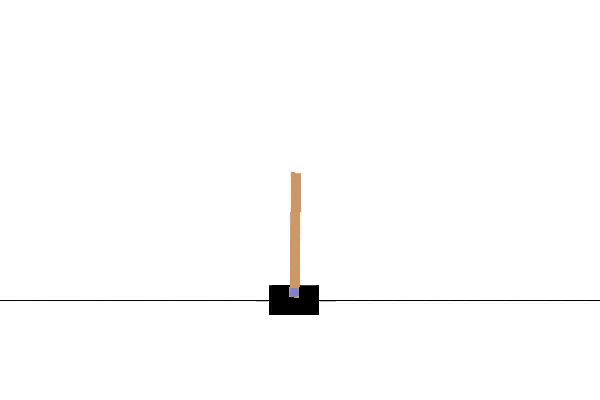
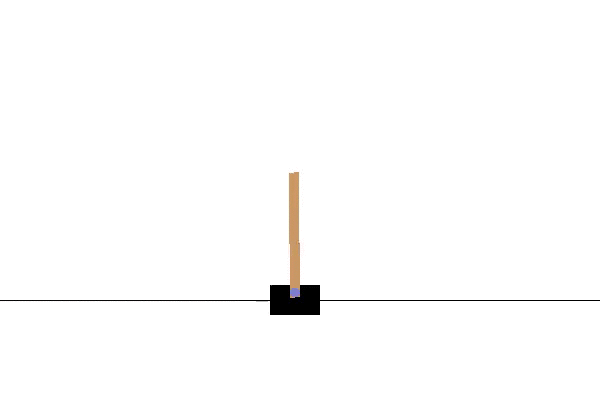
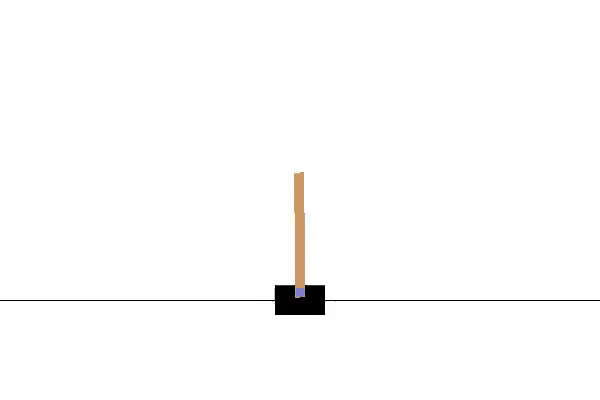

In [78]:
HTML(data=get_gif_html(env.videos))